In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts
import EpiClockNBL.Select_fCpGs.util as local_util
import EpiClockNBL.src.maxima as maxima

In [25]:
proj_dir = os.path.join(pc_consts['official_indir'], 'TARGET')

In [3]:
# Import clinical table
clinical = pd.read_table(
    os.path.join(proj_dir, 'clinical.annotated.tsv'), index_col=0
)

# Follow-up data

In [5]:
follow_up = pd.read_table(os.path.join(proj_dir, 'follow_up.tsv'), na_values=["'--"])

In [6]:
follow_up['timepoint_category'].value_counts()

timepoint_category
Follow-up       1202
Last Contact     840
Name: count, dtype: int64

In [7]:
# These two columns are equal
df_compare = follow_up[['timepoint_category', 'timepoint_category.1']].dropna().reset_index()
assert (df_compare['timepoint_category'] == df_compare['timepoint_category.1']).all()
assert follow_up.loc[(follow_up['timepoint_category'] != follow_up['timepoint_category.1']),
              ['timepoint_category', 'timepoint_category.1']].isna().all(axis=1).all()

In [8]:
timepoint_category_counts = follow_up.groupby('case_submitter_id')['timepoint_category'].value_counts().unstack()
timepoint_category_counts

timepoint_category,Follow-up,Last Contact
case_submitter_id,,
TARGET-30-PAAPFA,1,1
TARGET-30-PADPHP,1,1
TARGET-30-PADSEC,1,1
TARGET-30-PAHYWC,1,1
TARGET-30-PAICGF,1,1
...,...,...
TARGET-30-PAVDPE,1,1
TARGET-30-PAVDYS,1,1
TARGET-30-PAVEKN,1,1


In [9]:
display(follow_up.iloc[0, :50])
display(follow_up.iloc[0, 50:100])
display(follow_up.iloc[0, 100:])

case_id                                     001c294c-5ae8-55cd-bf07-88112e9b117b
case_submitter_id                                               TARGET-30-PASWVY
project_id                                                            TARGET-NBL
adverse_event                                                                NaN
adverse_event_grade                                                          NaN
aids_risk_factors                                                            NaN
barretts_esophagus_goblet_cells_present                                      NaN
bmi                                                                          NaN
body_surface_area                                                            NaN
cause_of_response                                                            NaN
cd4_count                                                                    NaN
cdc_hiv_risk_factors                                                         NaN
comorbidities               

hysterectomy_margins_involved                       NaN
hysterectomy_type                                   NaN
imaging_anatomic_site                               NaN
imaging_findings                                    NaN
imaging_result                                      NaN
imaging_suv                                         NaN
imaging_suv_max                                     NaN
imaging_type                                        NaN
immunosuppressive_treatment_type                    NaN
karnofsky_performance_status                        NaN
menopause_status                                    NaN
nadir_cd4_count                                     NaN
pancreatitis_onset_year                             NaN
peritoneal_washing_results                          NaN
pregnancy_count                                     NaN
pregnancy_outcome                                   NaN
procedures_performed                                NaN
progression_or_recurrence                       

clonality                               NaN
copy_number                             NaN
cytoband                                NaN
days_to_test                            NaN
exon                                    NaN
gene_symbol                             NaN
histone_family                          NaN
histone_variant                         NaN
hpv_strain                              NaN
intron                                  NaN
laboratory_test                         NaN
loci_abnormal_count                     NaN
loci_count                              NaN
locus                                   NaN
mismatch_repair_mutation                NaN
mitotic_count                           NaN
mitotic_total_area                      NaN
molecular_analysis_method               NaN
molecular_consequence                   NaN
molecular_test_id                       NaN
molecular_test_submitter_id             NaN
mutation_codon                          NaN
pathogenicity                   

In [10]:
print(timepoint_category_counts['Follow-up'].value_counts())
print(timepoint_category_counts['Last Contact'].value_counts())

Follow-up
1    578
2    193
3     45
4     19
5      3
6      2
Name: count, dtype: int64
Last Contact
1    840
Name: count, dtype: int64


In [11]:
timepoint_category_counts

timepoint_category,Follow-up,Last Contact
case_submitter_id,,
TARGET-30-PAAPFA,1,1
TARGET-30-PADPHP,1,1
TARGET-30-PADSEC,1,1
TARGET-30-PAHYWC,1,1
TARGET-30-PAICGF,1,1
...,...,...
TARGET-30-PAVDPE,1,1
TARGET-30-PAVDYS,1,1
TARGET-30-PAVEKN,1,1


In [12]:
assert clinical.index.isin(timepoint_category_counts.index).all()

## Merge follow-up data into clinical table

In [13]:
follow_up_selected = follow_up.loc[follow_up['case_submitter_id'].isin(clinical.index) & (follow_up['timepoint_category']=='Last Contact'),
                                   ['case_submitter_id', 'days_to_follow_up', 'year_of_follow_up']].set_index('case_submitter_id')
clinical = clinical.merge(follow_up_selected, left_index=True, right_index=True, how='left')

In [14]:
clinical['primary_site'].value_counts()

primary_site
Adrenal gland                                                             74
Other and ill-defined sites                                               37
Retroperitoneum and peritoneum                                            16
Unknown                                                                    8
Kidney                                                                     4
Heart, mediastinum, and pleura                                             4
Peripheral nerves and autonomic nervous system                             2
Liver and intrahepatic bile ducts                                          1
Other endocrine glands and related structures                              1
Skin                                                                       1
Lymph nodes                                                                1
Connective, subcutaneous and other soft tissues                            1
Spinal cord, cranial nerves, and other parts of central nervous

In [15]:
years_btw = clinical['year_of_follow_up'] - clinical['year_of_diagnosis']
assert (clinical['days_to_diagnosis'] == 0).all()
days_btw = clinical['days_to_follow_up']
matching = np.abs(days_btw/365 - years_btw) < 1
matching.mean()

np.float64(0.9735099337748344)

(array([26., 22., 12., 15., 11.,  9., 19., 24.,  7.,  6.]),
 array([ 0.23835616,  1.56684932,  2.89534247,  4.22383562,  5.55232877,
         6.88082192,  8.20931507,  9.53780822, 10.86630137, 12.19479452,
        13.52328767]),
 <BarContainer object of 10 artists>)

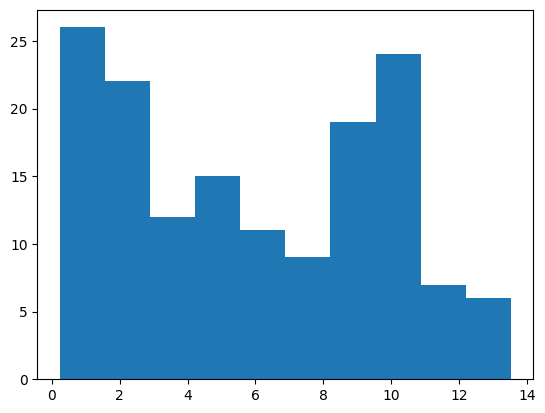

In [16]:
plt.hist(clinical['days_to_follow_up']/365)

(array([ 2.,  0.,  2.,  3., 25., 37., 14., 21., 27., 20.]),
 array([-14.52876712, -11.9260274 ,  -9.32328767,  -6.72054795,
         -4.11780822,  -1.51506849,   1.08767123,   3.69041096,
          6.29315068,   8.89589041,  11.49863014]),
 <BarContainer object of 10 artists>)

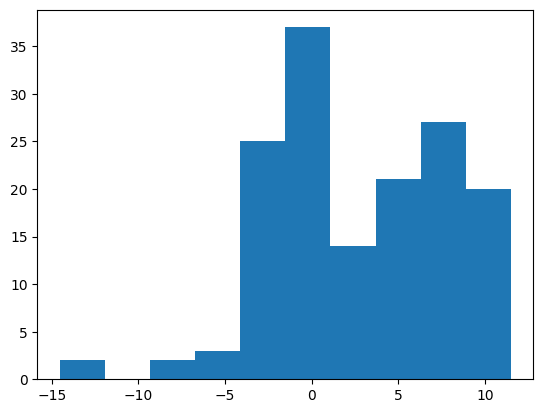

In [17]:
plt.hist((clinical['days_to_follow_up'] - clinical['age_at_diagnosis'])/365)

In [18]:
clinical['age_at_diagnosis']

submitter_id
TARGET-30-PASUCB    1008.0
TARGET-30-PASNPG     318.0
TARGET-30-PARNEE    1071.0
TARGET-30-PALXTB     635.0
TARGET-30-PAMMXF    1661.0
                     ...  
TARGET-30-PALVVH     219.0
TARGET-30-PATYIL     328.0
TARGET-30-PAPBGH    1074.0
TARGET-30-PAREGK     568.0
TARGET-30-PAMZSH     315.0
Name: age_at_diagnosis, Length: 151, dtype: float64

In [19]:
np.abs(clinical['days_to_follow_up']/365 - years_btw)

submitter_id
TARGET-30-PASUCB    0.172603
TARGET-30-PASNPG    0.263014
TARGET-30-PARNEE    0.128767
TARGET-30-PALXTB    0.339726
TARGET-30-PAMMXF    0.460274
                      ...   
TARGET-30-PALVVH    0.019178
TARGET-30-PATYIL    0.317808
TARGET-30-PAPBGH    0.019178
TARGET-30-PAREGK    0.142466
TARGET-30-PAMZSH    0.134247
Length: 151, dtype: float64

In [20]:
days_btw[~matching] / 365

submitter_id
TARGET-30-PARZCJ    10.665753
TARGET-30-PASXRG     9.857534
TARGET-30-PASFIC    10.498630
TARGET-30-PASWYR     9.372603
Name: days_to_follow_up, dtype: float64

In [21]:
clinical.loc['TARGET-30-PASXRG', ['year_of_follow_up', 'year_of_diagnosis']]

year_of_follow_up    2014.0
year_of_diagnosis    2009.0
Name: TARGET-30-PASXRG, dtype: object

In [22]:
years_btw[~matching]

submitter_id
TARGET-30-PARZCJ    9.0
TARGET-30-PASXRG    5.0
TARGET-30-PASFIC    9.0
TARGET-30-PASWYR    8.0
dtype: float64

In [23]:
clinical.to_csv(os.path.join(proj_dir, 'clinical.annotated.survival.tsv'), sep='\t')

## Missing cases - not in our selected NB cases anyway
Just wanted to check it out

In [24]:
all_cases = follow_up['case_submitter_id'].unique()
missing_cases = all_cases[~np.isin(all_cases, timepoint_category_counts.index)]
print(missing_cases)
df = follow_up.loc[follow_up['case_submitter_id'].isin(missing_cases)]
display(df.iloc[:, :int(df.shape[1]/3)].T)
display(df.iloc[:, int(df.shape[1]/3):2*int(df.shape[1]/3)].T)
display(df.iloc[:, 2*int(df.shape[1]/3):].T)

['TARGET-30-PAPRMJ' 'TARGET-30-PARCRR']


,1831,1832,3336,3337
case_id,7c8f4b8d-f27a-5295-b945-bbd1de2ed7c8,7c8f4b8d-f27a-5295-b945-bbd1de2ed7c8,e65ca63f-72b9-5532-835e-1acbd731c6b2,e65ca63f-72b9-5532-835e-1acbd731c6b2
case_submitter_id,TARGET-30-PAPRMJ,TARGET-30-PAPRMJ,TARGET-30-PARCRR,TARGET-30-PARCRR
project_id,TARGET-NBL,TARGET-NBL,TARGET-NBL,TARGET-NBL
adverse_event,NaN,NaN,NaN,NaN
adverse_event_grade,NaN,NaN,NaN,NaN
aids_risk_factors,NaN,NaN,NaN,NaN
barretts_esophagus_goblet_cells_present,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN
body_surface_area,NaN,NaN,NaN,NaN
cause_of_response,NaN,NaN,NaN,NaN


,1831,1832,3336,3337
hormonal_contraceptive_type,NaN,NaN,NaN,NaN
hormonal_contraceptive_use,NaN,NaN,NaN,NaN
hormone_replacement_therapy_type,NaN,NaN,NaN,NaN
hpv_positive_type,NaN,NaN,NaN,NaN
hysterectomy_margins_involved,NaN,NaN,NaN,NaN
hysterectomy_type,NaN,NaN,NaN,NaN
imaging_anatomic_site,NaN,NaN,NaN,NaN
imaging_findings,NaN,NaN,NaN,NaN
imaging_result,NaN,NaN,NaN,NaN
imaging_suv,NaN,NaN,NaN,NaN


,1831,1832,3336,3337
biospecimen_type,NaN,NaN,NaN,NaN
biospecimen_volume,NaN,NaN,NaN,NaN
blood_test_normal_range_lower,NaN,NaN,NaN,NaN
blood_test_normal_range_upper,NaN,NaN,NaN,NaN
cell_count,NaN,NaN,NaN,NaN
chromosomal_translocation,NaN,NaN,NaN,NaN
chromosome,NaN,NaN,NaN,NaN
chromosome_arm,NaN,NaN,NaN,NaN
clonality,NaN,NaN,NaN,NaN
copy_number,NaN,NaN,NaN,NaN
